In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

In [2]:
cols = [
    'ID',
    'diagnosis',
    'radius_m',
    'texture_m',
    'perimeter_m',
    'area_m',
    'smoothness_m',
    'compactness_m',
    'concavity_m',
    'concave_points_m',
    'symmetry_m',
    'fractal_dimension_m',
    'radius_se',
    'texture_se',
    'perimeter_se',
    'area_se',
    'smoothness_se',
    'compactness_se',
    'concavity_se',
    'concave_points_se',
    'symmetry_se',
    'fractal_dimension_se',
    'radius_w',
    'texture_w',
    'perimeter_w',
    'area_w',
    'smoothness_w',
    'compactness_w',
    'concavity_w',
    'concave_points_w',
    'symmetry_w',
    'fractal_dimension_w']

In [3]:
def serialize(obj):
    with open('pickle_files/'+namestr(obj)+'.pickle','wb') as f:
        pk.dump(obj,f,pk.HIGHEST_PROTOCOL)
        
def load(obj):
    with open('pickle_files/'+obj+'.pickle','rb') as f:
        return pk.load(f)

def namestr(obj):
    g = globals()
    return [name for name in g if g[name] is obj][0]

### Load dataset from .data file

In [4]:
with open('wdbc.data') as file:
    l = file.read().splitlines()
    l = [i.split(',') for i in l]
    data_set = pd.DataFrame(l, columns=cols)
    for i in data_set:
        data_set[i] = pd.to_numeric(data_set[i],errors='ignore')
    
    data_set = data_set.sample(frac=1).reset_index(drop=True)
    serialize(data_set)

### Load dataset from pickle file

In [5]:
data_set = load('data_set')

# M => 1, B => 0
data_set.replace('B', 0, inplace=True)
data_set.replace('M', 1, inplace=True)

X = data_set.iloc[:,2:]
y = data_set.iloc[:,1]

### Normalization

In [6]:
std = np.apply_along_axis(np.std,0,X)
mean = np.apply_along_axis(np.mean,0,X)

for i in range(len(X.columns)):
    X.iloc[:,i] -= mean[i]
    X.iloc[:,i] /= std[i]

In [7]:
data_set

,ID,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,...,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
0,869104,1,16.110,18.05,105.10,813.0,0.09721,0.11370,0.09447,0.05943,...,19.92,25.27,129.00,1233.0,0.13140,0.22360,0.28020,0.12160,0.2792,0.08158
1,8911164,0,11.890,17.36,76.20,435.6,0.12250,0.07210,0.05929,0.07404,...,12.40,18.99,79.46,472.4,0.13590,0.08368,0.07153,0.08946,0.2220,0.06033
2,864018,0,11.340,21.26,72.48,396.5,0.08759,0.06575,0.05133,0.01899,...,13.01,29.15,83.99,518.1,0.16990,0.21960,0.31200,0.08278,0.2829,0.08832
3,911150,0,14.530,19.34,94.25,659.7,0.08388,0.07800,0.08817,0.02925,...,16.30,28.39,108.10,830.5,0.10890,0.26490,0.37790,0.09594,0.2471,0.07463
4,86135501,1,14.480,21.46,94.25,648.2,0.09444,0.09947,0.12040,0.04938,...,16.21,29.25,108.40,808.9,0.13060,0.19760,0.33490,0.12250,0.3020,0.06846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,859464,0,9.465,21.01,60.11,269.4,0.10440,0.07773,0.02172,0.01504,...,10.41,31.56,67.03,330.7,0.15480,0.16640,0.09412,0.06517,0.2878,0.09211
565,8811523,0,11.890,18.35,77.32,432.2,0.09363,0.11540,0.06636,0.03142,...,13.25,27.10,86.20,531.2,0.14050,0.30460,0.28060,0.11380,0.3397,0.08365
566,877500,1,14.450,20.22,94.49,642.7,0.09872,0.12060,0.11800,0.05980,...,18.33,30.12,117.90,1044.0,0.15520,0.40560,0.49670,0.18380,0.4753,0.10130
567,90401602,0,12.800,17.46,83.05,508.3,0.08044,0.08895,0.07390,0.04083,...,13.74,21.06,90.72,591.0,0.09534,0.18120,0.19010,0.08296,0.1988,0.07053


### Confusion matrix functions

In [8]:
def tp(y, p):
    return sum(np.logical_and(y,p))

def fp(y, p):
    return sum(np.logical_and(np.logical_not(y),p))

def tn(y, p):
    return sum(np.logical_not(np.logical_or(y,p)))

def fn(y, p):
    return sum(np.logical_and(y,np.logical_not(p)))

### Metrics

In [9]:
def accuracy(y_true, y_prediction):
    return sum(np.logical_not(np.logical_xor(y_true, y_prediction)))/len(y_true)

def precision(y_true, y_prediction):
    true_positive  = tp(y_true, y_prediction)
    false_positive = fp(y_true, y_prediction)
    return true_positive / (true_positive + false_positive)

def recall(y_true, y_prediction):
    true_positive  = tp(y_true, y_prediction)
    false_negative = fn(y_true, y_prediction)
    return true_positive / (true_positive + false_negative)

def specifity(y_true, y_prediction):
    false_positive = fp(y_true, y_prediction)
    true_negative  = tn(y_true, y_prediction)
    return true_negative / (false_positive + true_negative)

def roc_auc(y_true, y_prediction):
    tpr = recall(y_true, y_prediction)
    fpr = 1 - specifity(y_true, y_prediction)
    return (tpr*fpr/2)+((tpr+1)/2)*(1-fpr)

### Training and Testing functions

In [10]:
def predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    return model.predict(x_test)

def score(y_test, prediction):
    score = []
    score.append(accuracy(y_test, prediction))
    score.append(precision(y_test, prediction))
    score.append(recall(y_test, prediction))
    score.append(roc_auc(y_test, prediction))
    return np.array(score)

In [11]:
def cross_validation(X, y, n):
    options = []
    
    for i in range(n):
        X_folds = np.array_split(X, n)
        y_folds = np.array_split(y, n)
        
        x_test = X_folds.pop(i)
        y_test = y_folds.pop(i)

        options.append([pd.concat(X_folds),pd.concat(y_folds),x_test,y_test])
        
    return options

In [12]:
def result(model, X, y, n_fold):
    folds_option = cross_validation(X, y, n_fold)
    scores = []
    for i in folds_option:
        if len(scores):
            scores += score(i[3],predict(model, *i))
        else:
            scores = score(i[3],predict(model, *i))
    scores /= n_fold
    return {'accuracy' : scores[0], 
            'precision': scores[1], 
            'recall' : scores[2], 
            'auc' : scores[3]}

## Custom MLP

In [13]:
class MLP: 
    
    def __init__(self, 
                 num_perceptrons  = 128, 
                 activation       = tf.nn.relu, 
                 solver           = tf.train.AdamOptimizer, 
                 learning_rate    = .01, 
                 regularizer_rate = .1,
                 epochs           = 15, 
                 dropout_rate     = .6):
    
        self.num_perceptrons  = num_perceptrons
        self.activation       = activation
        self.solver           = solver
        self.learning_rate    = learning_rate
        self.regularizer_rate = regularizer_rate
        self.epochs           = epochs
        self.dropout_rate     = dropout_rate

    def fit(self, X, y):
        
        self.s = tf.get_default_session()
        if not self.s:
            self.s = tf.InteractiveSession()
            
        self.X_train = X
        self.y_train = y
        
        # initial data
        X      = np.array(X)     
        y      = np.array(y).reshape((-1,1))
        self.X_input = tf.placeholder('float', shape=(None, X.shape[1]), name='X')
        self.y_input = tf.placeholder('float', shape=(None, y.shape[1]), name='y')
        self.drop_rate = tf.placeholder('float')
        
        # initialize weights & bias
        weights_0 = tf.Variable(tf.random_normal([X.shape[1],self.num_perceptrons], 
                                                 stddev=(1/tf.sqrt(float(X.shape[1])))))
        bias_0    = tf.Variable(tf.random_normal([self.num_perceptrons]))

        weights_1 = tf.Variable(tf.random_normal([self.num_perceptrons,y.shape[1]], 
                                                 stddev=(1/tf.sqrt(float(self.num_perceptrons)))))
        bias_1    = tf.Variable(tf.random_normal([y.shape[1]]))
        
        # define layers
        hidden_output  = self.activation(tf.matmul(self.X_input, weights_0)+bias_0)
        dropped_output = tf.nn.dropout(hidden_output, rate=self.drop_rate)

        output         = tf.matmul(dropped_output,weights_1) + bias_1
        mean, std      = tf.nn.moments(output,0)
        self.predicted = tf.sigmoid((output - mean)/tf.sqrt(std))
        
        # optimization
        loss      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.predicted,
                                                                              labels=self.y_input))\
        + self.regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(loss,var_list=[weights_0,
                                                                                       weights_1,
                                                                                       bias_0,
                                                                                       bias_1])
        # training
        self.s.run(tf.global_variables_initializer())
        for i in range(self.epochs):
            self.s.run(optimizer, {self.X_input:X, self.y_input:y, self.drop_rate:self.dropout_rate})
        

        
    def predict(self, x_test):
        prediction = self.s.run(self.predicted, {self.X_input:x_test, self.drop_rate:0})
        return np.where(prediction.reshape((-1,))>.5,1,0)

## Result

In [14]:
results = {}

results['logistic']    = result(LogisticRegression(max_iter=3000), X, y, 5)

results['svm']         = result(svm.SVC(), X, y, 5)

results['library_mlp'] = result(MLPClassifier(max_iter = 400, activation='relu'), X, y, 5)

results['custom_mlp']  = result(MLP(learning_rate=.025),X,y,5)

In [15]:
def plot(label='accuracy'):
    y_pos = np.arange(len(results))
    performance = [i[label] for i in results.values()]

    plt.bar(y_pos, performance)
    plt.xticks(y_pos, results.keys())
    plt.ylabel(label)
    plt.ylim(bottom=min(performance)-.05)

    plt.show()

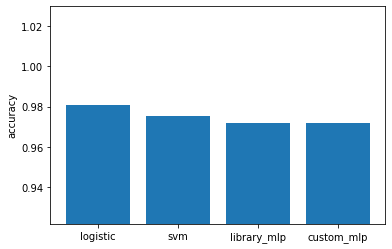

In [16]:
plot('accuracy')

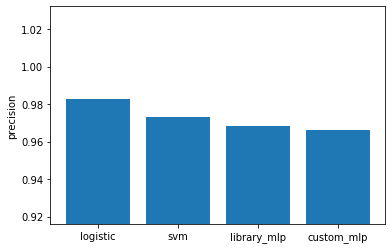

In [17]:
plot('precision')

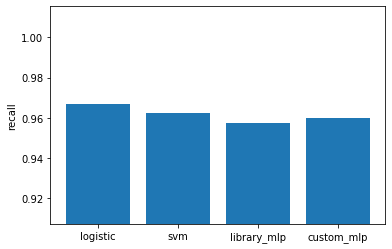

In [18]:
plot('recall')

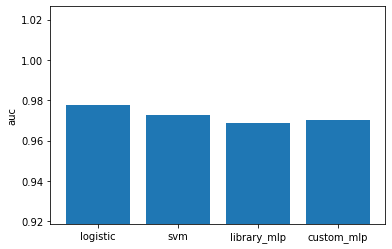

In [19]:
plot('auc')

In [20]:
results['custom_mlp']

{'accuracy': 0.9718677224033534,
 'precision': 0.9661611811107891,
 'recall': 0.9598770074517583,
 'auc': 0.9701455000198319}

In [21]:
results['library_mlp']

{'accuracy': 0.9719142990218911,
 'precision': 0.968178911880958,
 'recall': 0.9572274348021855,
 'auc': 0.9686284770851727}

In [22]:
results['logistic']

{'accuracy': 0.9806862288464524,
 'precision': 0.9829787234042552,
 'recall': 0.9670713413570556,
 'auc': 0.9776493830531099}

In [23]:
results['svm']

{'accuracy': 0.9754075454122031,
 'precision': 0.9730275429165346,
 'recall': 0.9626268969126113,
 'auc': 0.9726673587753109}